In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')
sns.set_palette('Set2')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

In [2]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
data = pd.concat([train_data, test_data]).reset_index().drop(['index'], axis=1)

str_cols = data.select_dtypes(include=["object"]).columns
data[str_cols] = (data[str_cols]
                .apply(lambda s: s.str.strip())
                .replace(r"^\s*$", np.nan, regex=True))

# Kaggle互換の Survived が欲しい場合（Perished があるときだけ）
if "Perished" in data and "Survived" not in data:
    data["Survived"] = 1 - data["Perished"]

In [3]:
data['Surname'] = data['Name'].apply(lambda x: x.split(',')[0])


In [4]:
# New Ticket_id column
data['Ticket_id'] = 'new_col'
# Initialize Ticket_id = Pclass + Ticket + Fare + Embarked
def ticket_id(row):
    row['Ticket_id'] = str(row.Pclass) + '-' + str(row.Ticket)[:-1] + '-' + str(row.Fare) + '-' + str(row.Embarked)
    return row

data = data.apply(ticket_id, axis='columns')
# New Group_id column
data['Group_id'] = 'new_col2'
# Initialize Group_id = Surname + Ticket_id
def group_id(row):
    row['Group_id'] = str(row.Surname) + '-' + str(row.Ticket_id)
    return row

data = data.apply(group_id, axis='columns')

In [5]:
# creation of the Title feature
data['Title'] = 'man'
data.loc[data.Sex == 'female', 'Title'] = 'woman'
data.loc[data['Name'].str.contains('Master'), 'Title'] = 'boy'

In [6]:
data.loc[data.Title == 'man', 'Group_id'] = 'noGroup'
# New column with WC frequency
data['WC_count'] = data.loc[data.Title != 'man'].groupby('Group_id')['Group_id'].transform('count')
# assign noGroup to every unique value
data.loc[data.WC_count <=1, 'Group_id'] = 'noGroup'

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


In [7]:
cols = ['PassengerId', 'Survived', 'Name', 'Title', 'Ticket_id','Group_id']
data.loc[(data.Ticket_id == '1-1696-134.5-C') & (data.Title != 'man'), cols]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Name,Title,Ticket_id,Group_id
319,320,1.0,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",woman,1-1696-134.5-C,Spedden-1-1696-134.5-C
337,338,1.0,"Burns, Miss. Elizabeth Margaret",woman,1-1696-134.5-C,noGroup
1087,1088,NaN,"Spedden, Master. Robert Douglas",boy,1-1696-134.5-C,Spedden-1-1696-134.5-C
1262,1263,NaN,"Wilson, Miss. Helen Alice",woman,1-1696-134.5-C,noGroup


In [8]:
indices = []
count = 0
for i in range(0,1309):
    if (data.loc[i,'Title'] != 'man') & (data.loc[i,'Group_id'] == 'noGroup'):
        data.loc[i,'Group_id'] = data.loc[(data['Ticket_id'] == data.loc[i, 'Ticket_id']) & (data.Title != 'man'), 'Group_id'].iloc[0]
        if (data.loc[i, 'Group_id'] != 'noGroup'):
            indices.append(i)
            count += 1
print('{:d} passengers were added to an existing group'.format(count))

11 passengers were added to an existing group


In [9]:
cols = ['PassengerId', 'Survived', 'Name', 'Title', 'Group_id']
data.loc[indices, cols]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Name,Title,Group_id
337,338,1.0,"Burns, Miss. Elizabeth Margaret",woman,Spedden-1-1696-134.5-C
708,709,1.0,"Cleaver, Miss. Alice",woman,Allison-1-11378-151.55-S
950,951,NaN,"Chaudanson, Miss. Victorine",woman,Ryerson-1-PC 1760-262.375-C
1032,1033,NaN,"Daniels, Miss. Sarah",woman,Allison-1-11378-151.55-S
1067,1068,NaN,"Sincock, Miss. Maude",woman,Davies-2-C.A. 3311-36.75-S
1140,1141,NaN,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",woman,Zabour-3-266-14.4542-C
1171,1172,NaN,"Oreskovic, Miss. Jelka",woman,Cacic-3-31508-8.6625-S
1258,1259,NaN,"Riihivouri, Miss. Susanna Juhantytar Sanni""""",woman,Panula-3-310129-39.6875-S
1262,1263,NaN,"Wilson, Miss. Helen Alice",woman,Spedden-1-1696-134.5-C
1266,1267,NaN,"Bowen, Miss. Grace Scott",woman,Ryerson-1-PC 1760-262.375-C


In [10]:
number_of_groups = data.loc[data.Group_id != 'noGroup', 'Group_id'].nunique()
print('Number of groups found: {:d}'.format(number_of_groups))
number_of_WCG_passengers = data.loc[data.Group_id != 'noGroup', 'Group_id'].count()
print('\nNumber of passengers in a group: {:d}'.format(number_of_WCG_passengers))
composition = data.loc[data.Group_id != 'noGroup','Title'].value_counts()
print('\nComposition of the groups:')
print(composition.to_string())

Number of groups found: 80

Number of passengers in a group: 230

Composition of the groups:
Title
woman    171
boy       59


In [11]:
data['WCSurvived'] = data.loc[(data.Title != 'man') & (data.Group_id != 'noGroup')].groupby('Group_id').Survived.transform('mean')

In [12]:
cols = ['PassengerId', 'Survived', 'WCSurvived', 'Name', 'Title', 'Group_id']
data.loc[data.Group_id == 'Sage-3-CA. 234-69.55-S', cols]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,WCSurvived,Name,Title,Group_id
159,160,0.0,0.0,"Sage, Master. Thomas Henry",boy,Sage-3-CA. 234-69.55-S
180,181,0.0,0.0,"Sage, Miss. Constance Gladys",woman,Sage-3-CA. 234-69.55-S
792,793,0.0,0.0,"Sage, Miss. Stella Anna",woman,Sage-3-CA. 234-69.55-S
863,864,0.0,0.0,"Sage, Miss. Dorothy Edith ""Dolly""",woman,Sage-3-CA. 234-69.55-S
1079,1080,NaN,0.0,"Sage, Miss. Ada",woman,Sage-3-CA. 234-69.55-S
1251,1252,NaN,0.0,"Sage, Master. William Henry",boy,Sage-3-CA. 234-69.55-S
1256,1257,NaN,0.0,"Sage, Mrs. John (Annie Bullen)",woman,Sage-3-CA. 234-69.55-S


WCSurvived all data values:
WCSurvived
1.00    134
0.00     76
0.75      6
0.50      5


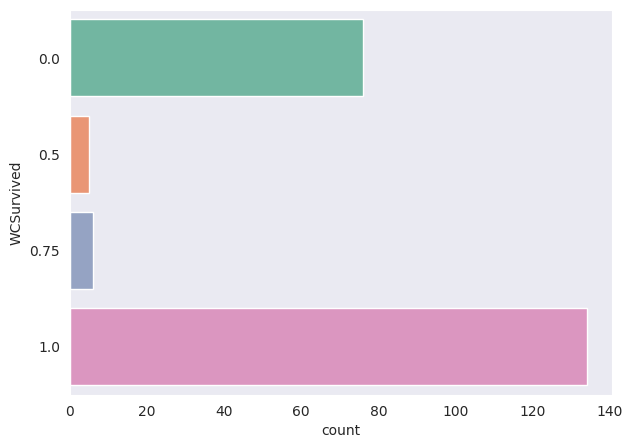

In [13]:
print('WCSurvived all data values:')
print(data.WCSurvived.value_counts().to_string())
plt.figure(figsize=(7,5))
f = sns.countplot(y=data.WCSurvived)

In [14]:
data.loc[(data.WCSurvived==0.75) | (data.WCSurvived==0.5), cols].sort_values(by='Group_id')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,WCSurvived,Name,Title,Group_id
297,298,0.0,0.50,"Allison, Miss. Helen Loraine",woman,Allison-1-11378-151.55-S
305,306,1.0,0.50,"Allison, Master. Hudson Trevor",boy,Allison-1-11378-151.55-S
498,499,0.0,0.50,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",woman,Allison-1-11378-151.55-S
708,709,1.0,0.50,"Cleaver, Miss. Alice",woman,Allison-1-11378-151.55-S
1032,1033,NaN,0.50,"Daniels, Miss. Sarah",woman,Allison-1-11378-151.55-S
25,26,1.0,0.75,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",woman,Asplund-3-34707-31.3875-S
182,183,0.0,0.75,"Asplund, Master. Clarence Gustaf Hugo",boy,Asplund-3-34707-31.3875-S
233,234,1.0,0.75,"Asplund, Miss. Lillian Gertrud",woman,Asplund-3-34707-31.3875-S
261,262,1.0,0.75,"Asplund, Master. Edvin Rojj Felix",boy,Asplund-3-34707-31.3875-S
1045,1046,NaN,0.75,"Asplund, Master. Filip Oscar",boy,Asplund-3-34707-31.3875-S


In [15]:
# Get the family names using set difference
test_groups = set(data[891:1309].Group_id.unique()) - set(data[0:891].Group_id.unique())
data.loc[data.Group_id.isin(test_groups), cols].sort_values(by='Group_id')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,WCSurvived,Name,Title,Group_id
1259,1260,NaN,NaN,"Gibson, Mrs. Leonard (Pauline C Boeson)",woman,Gibson-1-11237-59.4-C
1293,1294,NaN,NaN,"Gibson, Miss. Dorothy Winifred",woman,Gibson-1-11237-59.4-C
1044,1045,NaN,NaN,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",woman,Klasen-3-35040-12.1833-S
1154,1155,NaN,NaN,"Klasen, Miss. Gertrud Emilia",woman,Klasen-3-35040-12.1833-S
1050,1051,NaN,NaN,"Peacock, Mrs. Benjamin (Edith Nile)",woman,Peacock-3-SOTON/O.Q. 310131-13.775-S
1172,1173,NaN,NaN,"Peacock, Master. Alfred Edward",boy,Peacock-3-SOTON/O.Q. 310131-13.775-S
1300,1301,NaN,NaN,"Peacock, Miss. Treasteall",woman,Peacock-3-SOTON/O.Q. 310131-13.775-S
1083,1084,NaN,NaN,"van Billiard, Master. Walter John",boy,van Billiard-3-A/5. 85-14.5-S
1235,1236,NaN,NaN,"van Billiard, Master. James William",boy,van Billiard-3-A/5. 85-14.5-S


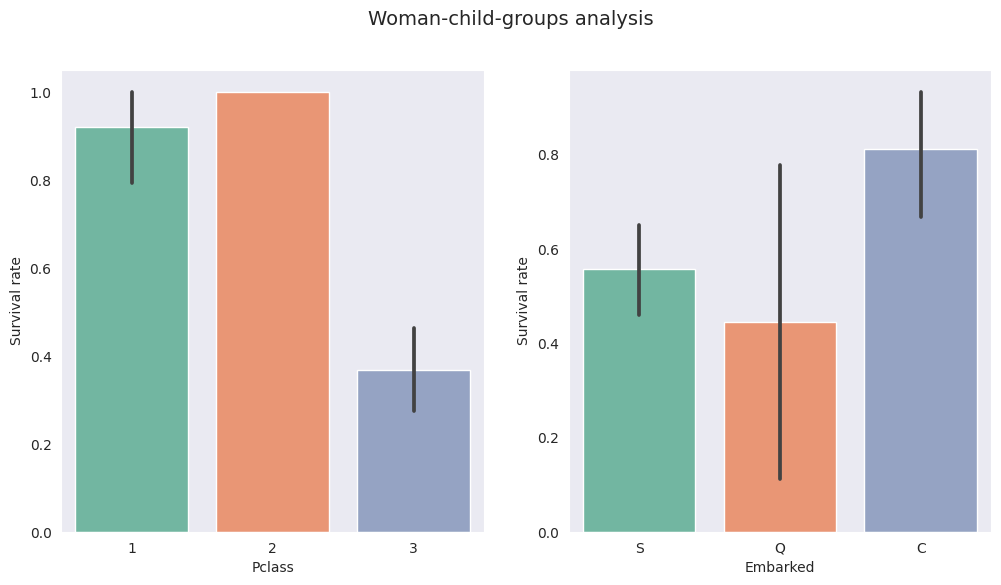

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Woman-child-groups analysis', fontsize=14)
a = sns.barplot(x='Pclass', y='Survived', data=data[data.Group_id != 'noGroup'], ax=ax[0]).set_ylabel('Survival rate')
b = sns.barplot(x='Embarked', y='Survived', data=data[data.Group_id != 'noGroup'], ax=ax[1]).set_ylabel('Survival rate')

In [17]:
# Assign WCSurvived = 0 to 3rd class test families, else 1
data.loc[data.Group_id.isin(test_groups), 'WCSurvived'] = 0
data.loc[(data.Group_id.isin(test_groups)) & (data.Pclass != 3), 'WCSurvived'] = 1

In [18]:
print('WCSurvived test values:')
print(data[891:1309].WCSurvived.value_counts().to_string())

WCSurvived test values:
WCSurvived
1.00    47
0.00    24
0.75     2
0.50     1


In [19]:
# Set everyone to 0
data.loc[891:1308, 'Predict'] = 0
# Set women to 1, completing the gender model
data.loc[891:1308, 'Predict'][(data.Sex == 'female')] = 1
# Change WCG women with WCSurvived=0 to 0
data.loc[891:1308,'Predict'][(data.Sex == 'female') & (data['WCSurvived'] == 0)] = 0
# Change WCG boys with WCSurvived=1 to 1, completing the WCG + gender model
data.loc[891:1308, 'Predict'][(data.Title == 'boy') & (data['WCSurvived'] == 1)] = 1
# With this, the three group members with non-integer WCSurvived are not changed from the gender model

/tmp/ipykernel_1558/1251712264.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data.loc[891:1308, 'Predict'][(data.Sex == 'female')] = 1
/tmp/ipykernel_1558/1251712264.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in

In [20]:
print('The following 8 males are predicted to live:')
cols = ['PassengerId', 'Name', 'Title', 'Group_id']
data[891:1309][cols].loc[(data.Title == 'boy') & (data.Predict == 1)]

The following 8 males are predicted to live:


,PassengerId,Name,Title,Group_id
955,956,"Ryerson, Master. John Borie",boy,Ryerson-1-PC 1760-262.375-C
980,981,"Wells, Master. Ralph Lester",boy,Wells-2-2910-23.0-S
1052,1053,"Touma, Master. Georges Youssef",boy,Touma-3-265-15.2458-C
1085,1086,"Drew, Master. Marshall Brines",boy,Drew-2-2822-32.5-S
1087,1088,"Spedden, Master. Robert Douglas",boy,Spedden-1-1696-134.5-C
1198,1199,"Aks, Master. Philip Frank",boy,Aks-3-39209-9.35-S
1283,1284,"Abbott, Master. Eugene Joseph",boy,Abbott-3-C.A. 267-20.25-S
1308,1309,"Peter, Master. Michael J",boy,Peter-3-266-22.3583-C


In [21]:
print('The following 15 females are predicted to die:')
data[891:1309][cols].loc[(data.Title == 'woman') & (data.Predict == 0)]

The following 15 females are predicted to die:


,PassengerId,Name,Title,Group_id
909,910,"Ilmakangas, Miss. Ida Livija",woman,Ilmakangas-3-STON/O2. 310127-7.925-S
924,925,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",woman,Johnston-3-W./C. 660-23.45-S
928,929,"Cacic, Miss. Manda",woman,Cacic-3-31508-8.6625-S
1023,1024,"Lefebre, Mrs. Frank (Frances)",woman,Lefebre-3-413-25.4667-S
1031,1032,"Goodwin, Miss. Jessie Allis",woman,Goodwin-3-CA 214-46.9-S
1044,1045,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)",woman,Klasen-3-35040-12.1833-S
1050,1051,"Peacock, Mrs. Benjamin (Edith Nile)",woman,Peacock-3-SOTON/O.Q. 310131-13.775-S
1079,1080,"Sage, Miss. Ada",woman,Sage-3-CA. 234-69.55-S
1140,1141,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",woman,Zabour-3-266-14.4542-C
1154,1155,"Klasen, Miss. Gertrud Emilia",woman,Klasen-3-35040-12.1833-S


In [22]:
print('The remaining 258 males are predicted to die')
print('and the remaining 137 females are predicted to live')

The remaining 258 males are predicted to die
and the remaining 137 females are predicted to live


In [23]:
output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_gender.csv', index=False)
print('WCG_gender submission was successfully saved!')
print('Submission is loading... you scored 81,6%!')

WCG_gender submission was successfully saved!
Submission is loading... you scored 81,6%!


In [24]:
# Assign np.NaN to zero-fares
def fix_fare(row):
    if row.Fare == 0:
        row.Fare = np.NaN
    return row
print('The following {:d} passengers have a zero Fare:'.format(data[data.Fare==0].shape[0]))
cols = ['PassengerId', 'Survived', 'Pclass','Fare', 'Name']
data.loc[data.Fare==0, cols]

The following 17 passengers have a zero Fare:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Fare,Name
179,180,0.0,3,0.0,"Leonard, Mr. Lionel"
263,264,0.0,1,0.0,"Harrison, Mr. William"
271,272,1.0,3,0.0,"Tornquist, Mr. William Henry"
277,278,0.0,2,0.0,"Parkes, Mr. Francis ""Frank"""
302,303,0.0,3,0.0,"Johnson, Mr. William Cahoone Jr"
413,414,0.0,2,0.0,"Cunningham, Mr. Alfred Fleming"
466,467,0.0,2,0.0,"Campbell, Mr. William"
481,482,0.0,2,0.0,"Frost, Mr. Anthony Wood ""Archie"""
597,598,0.0,3,0.0,"Johnson, Mr. Alfred"
633,634,0.0,1,0.0,"Parr, Mr. William Henry Marsh"


In [25]:
# fig, ax = plt.subplots(1,2,figsize=(12,8))
# fig.suptitle('Removing zero fares: before and after', fontsize=14)
# a = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[0])
# # ax[0].axhline(y=2, color='r')
# # Apply the fix_fare function 
# data = data.apply(fix_fare, axis='columns')
# ax[1].axhline(y=2, color='r')
# b = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[1])

In [26]:
# Calculate Ticket frequency and divide Fare by it
data['Ticket_freq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['Pfare'] = data['Fare'] / data['Ticket_freq']

In [27]:
# fig, ax = plt.subplots(1,2,figsize=(12,8))
# fig.suptitle('Fare and Pfare compared', fontsize=14)
# a = sns.swarmplot(x='Pclass', y='Fare', data=data, ax=ax[0])
# b = sns.swarmplot(x='Pclass', y='Pfare', data=data, ax=ax[1])

In [28]:
# Isolating adult males in train and test set
train_male = data[0:891].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]
test_male = data[891:1309].loc[(data.Sex=='male') & (data.WCSurvived.isnull())]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3544: UserWarning: 16.8% of the points cannot be placed; you may want to decrease the size of the mar

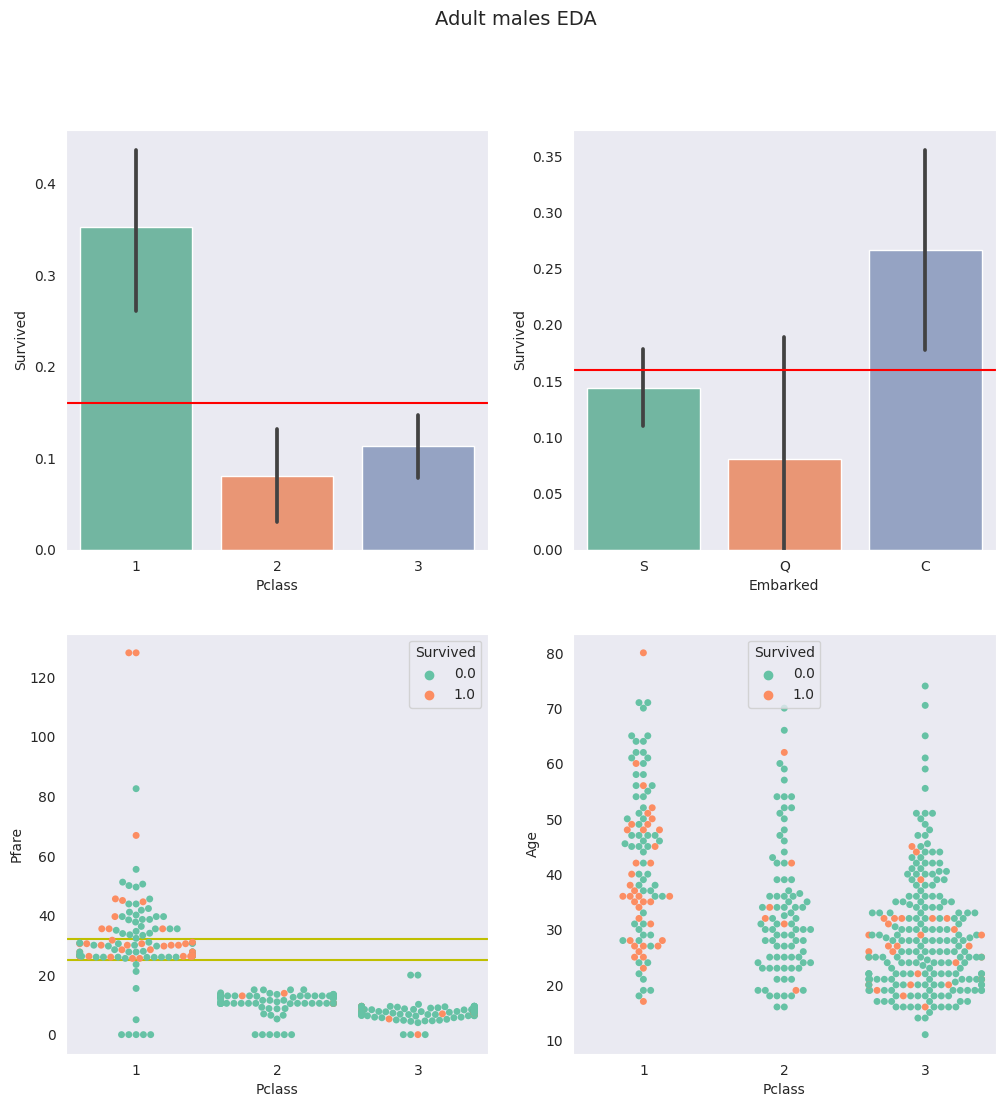

In [29]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Adult males EDA', fontsize=14)
sns.barplot(x='Pclass', y='Survived', data=train_male, ax=ax[0][0])
ax[0][0].axhline(y=train_male.Survived.mean(), color='r')
sns.barplot(x='Embarked', y='Survived', data=train_male, ax=ax[0][1])
ax[0][1].axhline(y=train_male.Survived.mean(), color='r')
sns.swarmplot(x='Pclass', y='Pfare', hue='Survived', data=train_male, ax=ax[1][0])
ax[1][0].axhline(y=25, color='y')
ax[1][0].axhline(y=32, color='y')
a = sns.swarmplot(y='Age', x='Pclass', hue='Survived', data=train_male, ax=ax[1][1])

/tmp/ipykernel_1558/3842579517.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1, bins=30, label = 'Survived', ax = ax[0], color = 'c')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_1558/3842579517.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an

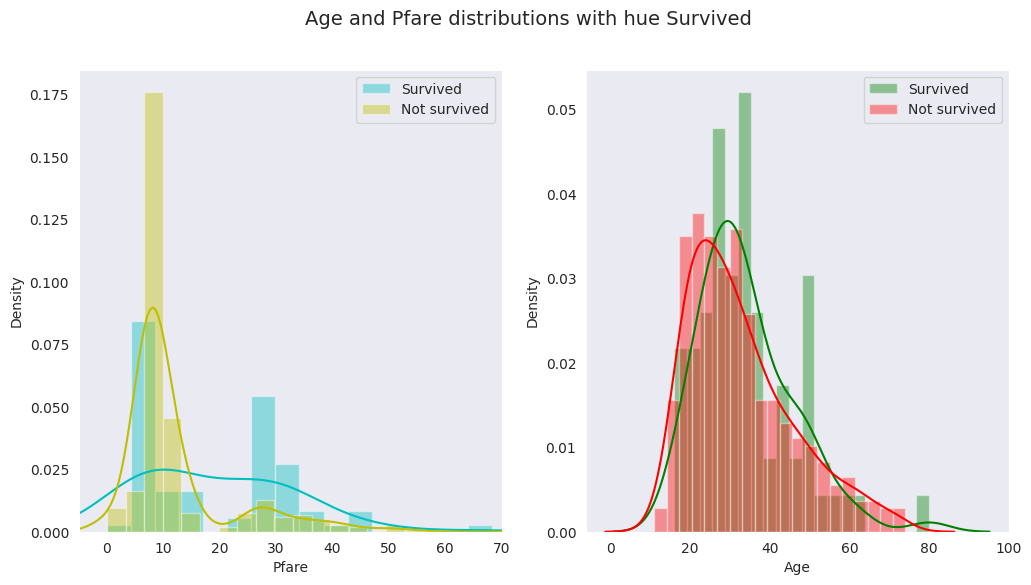

In [30]:
x1 = train_male.loc[train_male['Survived']==1, 'Pfare']
x0 = train_male.loc[train_male['Survived']==0, 'Pfare']
y1 = train_male.loc[train_male['Survived']==1, 'Age']
y0 = train_male.loc[train_male['Survived']==0, 'Age']

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Age and Pfare distributions with hue Survived', fontsize=14)
sns.distplot(x1, bins=30, label = 'Survived', ax = ax[0], color = 'c')
sns.distplot(x0, bins=25, label = 'Not survived', ax = ax[0], color = 'y')
ax[0].set_xlim(-5, 70)
ax[0].legend()
sns.distplot(y1, bins=20, label = 'Survived', ax = ax[1], color = 'g')
sns.distplot(y0, bins=20, label = 'Not survived', ax = ax[1], color = 'r')
ax[1].legend()
fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

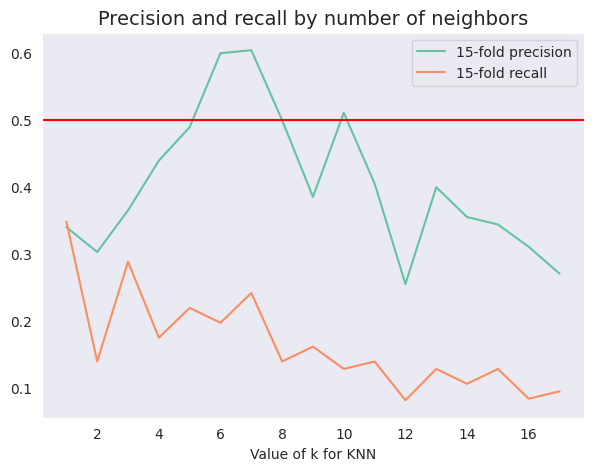

In [31]:
cols = ['PassengerId', 'Name', 'Pfare', 'Pclass', 'Embarked']
y_m = train_male['Survived']
features = ['Pfare', 'Pclass', 'Embarked']
X_m = train_male[features]

numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

precision_m = []
recall_m = []

for k in range(1,18):
    pipeline1 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    precision_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean())
    recall_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean())
    
k_range = range(1,18)
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_m, label='15-fold precision')
plt.plot(k_range, recall_m, label='15-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

In [32]:
m1 = KNeighborsClassifier(n_neighbors=1)
m2 = KNeighborsClassifier(n_neighbors=3)
m3 = KNeighborsClassifier(n_neighbors=7)
# Preprocessing is the same as before
male_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting',VotingClassifier([
        ('m1', m1), ('m2', m2), ('m3', m3)]))
])
print('15-fold precision of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean()))
print('15-fold recall of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean()))
print('15-fold accuracy of the ensemble: {:.3f}'.format(
    cross_val_score(male_pipeline, X_m, y_m, cv=15, n_jobs=-1).mean()))
# Fit model and make predictions
male_pipeline.fit(X_m, y_m)
learn_train_m = male_pipeline.predict(X_m)
X_test_m = test_male[features]
predictions_m = male_pipeline.predict(X_test_m)
print('\nThe following 9 adult males are predicted to live:')
test_male.loc[(predictions_m==1), cols]

15-fold precision of the ensemble: 0.404
15-fold recall of the ensemble: 0.267
15-fold accuracy of the ensemble: 0.816

The following 9 adult males are predicted to live:


,PassengerId,Name,Pfare,Pclass,Embarked
919,920,"Brady, Mr. John Bertram",30.500000,1,S
925,926,"Mock, Mr. Philipp Edmund",28.875000,1,C
930,931,"Hee, Mr. Ling",7.061975,3,S
941,942,"Smith, Mr. Lucien Philip",30.000000,1,S
959,960,"Tucker, Mr. Gilbert Milligan Jr",28.537500,1,C
985,986,"Birnbaum, Mr. Jakob",26.000000,1,C
986,987,"Tenglin, Mr. Gunnar Isidor",7.795800,3,S
1017,1018,"Brobeck, Mr. Karl Rudolf",7.795800,3,S
1022,1023,"Gracie, Col. Archibald IV",28.500000,1,C
1068,1069,"Stengel, Mr. Charles Emil Henry",27.720850,1,C


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3544: UserWarning: 12.6% of the points cannot be placed; you may want to decrease the size of the mar

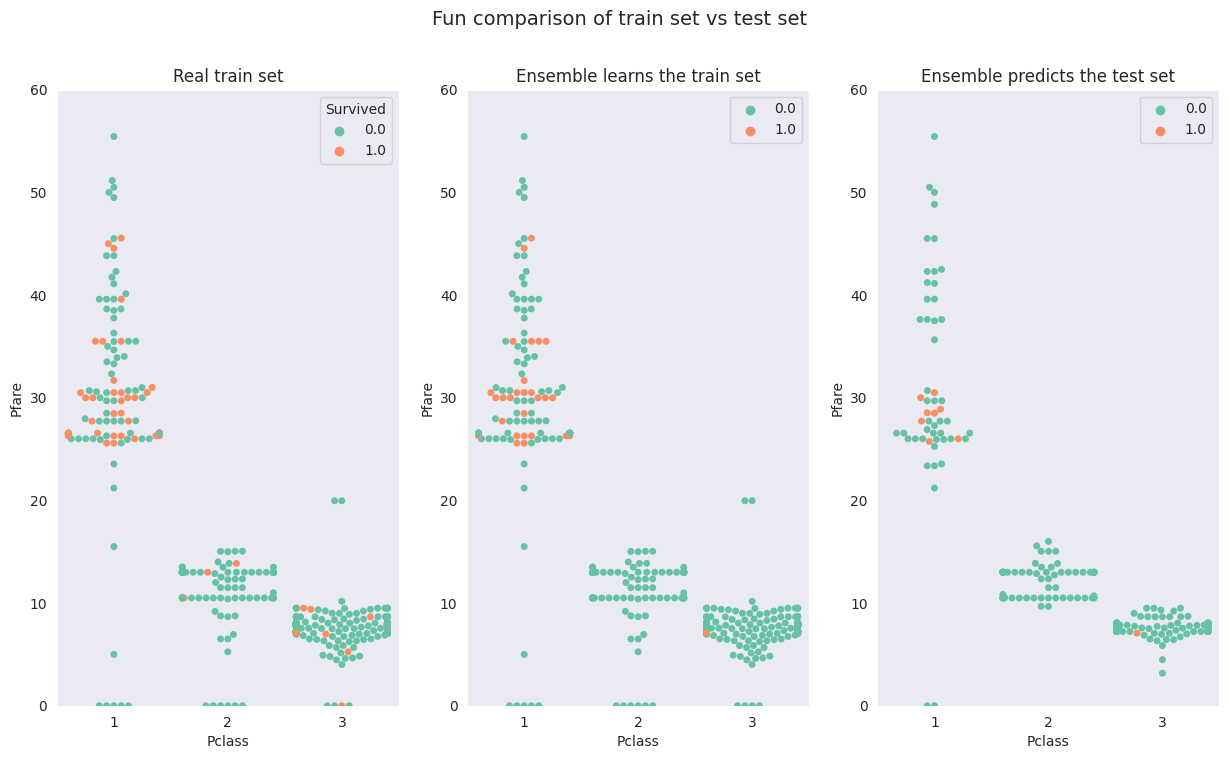

In [33]:
fig, ax = plt.subplots(1,3,figsize=(15,8))
fig.suptitle('Fun comparison of train set vs test set', fontsize=14)
ax[0].set_title('Real train set')
ax[0].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=y_m, ax=ax[0])
ax[1].set_title('Ensemble learns the train set')
ax[1].set_ylim(top=60)
sns.swarmplot(x=X_m.Pclass, y=X_m.Pfare, hue=learn_train_m,  ax=ax[1])
ax[2].set_title('Ensemble predicts the test set')
ax[2].set_ylim(top=60)
a = sns.swarmplot(x=test_male.Pclass, y=test_male.Pfare, hue=predictions_m,  ax=ax[2])

In [34]:
data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull())] = predictions_m
output = pd.DataFrame({'PassengerId': data[891:1309].PassengerId, 'Survived': data[891:1309].Predict.astype('int')})
output.to_csv('WCG_male.csv', index=False)
print('WCG_male submission was successfully saved!')
print('Submission is loading... you scored 82,3%!')

WCG_male submission was successfully saved!
Submission is loading... you scored 82,3%!


/tmp/ipykernel_1558/842615652.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data.loc[891:1308, 'Predict'][(data.Sex=='male') & (data.WCSurvived.isnull())] = predictions_m


In [35]:
train_female = data[0:891].loc[(data.Sex=='female')  & (data.WCSurvived.isnull())]
test_female = data[891:1309].loc[(data.Sex=='female') & (data.WCSurvived.isnull())]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3544: UserWarning: 26.5% of the points cannot be placed; you may want to decrease the size of the mar

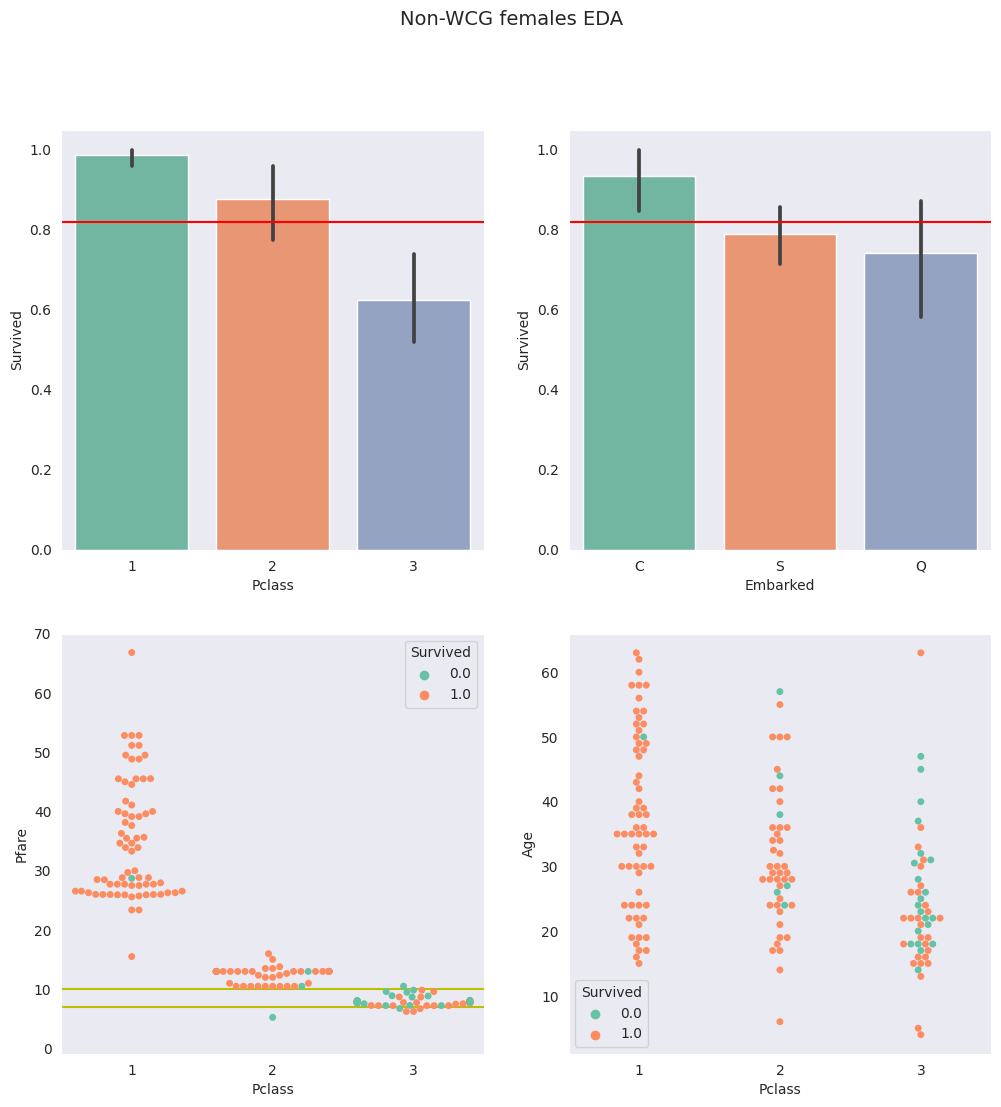

In [36]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
fig.suptitle('Non-WCG females EDA', fontsize=14)
sns.barplot(x='Pclass', y='Survived', data=train_female, ax=ax[0][0])
ax[0][0].axhline(y=train_female.Survived.mean(), color='r')
sns.barplot(x='Embarked', y='Survived', data=train_female, ax=ax[0][1])
ax[0][1].axhline(y=train_female.Survived.mean(), color='r')
sns.swarmplot(x='Pclass', y='Pfare', hue='Survived', data=train_female, ax=ax[1][0])
ax[1][0].set_ylim(top=70)
ax[1][0].axhline(y=7, color='y')
ax[1][0].axhline(y=10, color='y')
a = sns.swarmplot(y='Age', x='Pclass', hue='Survived', data=train_female, ax=ax[1][1])

/tmp/ipykernel_1558/727136883.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(w1, bins=35, label = 'Survived', ax = ax[0], color = 'c')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_1558/727136883.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an a

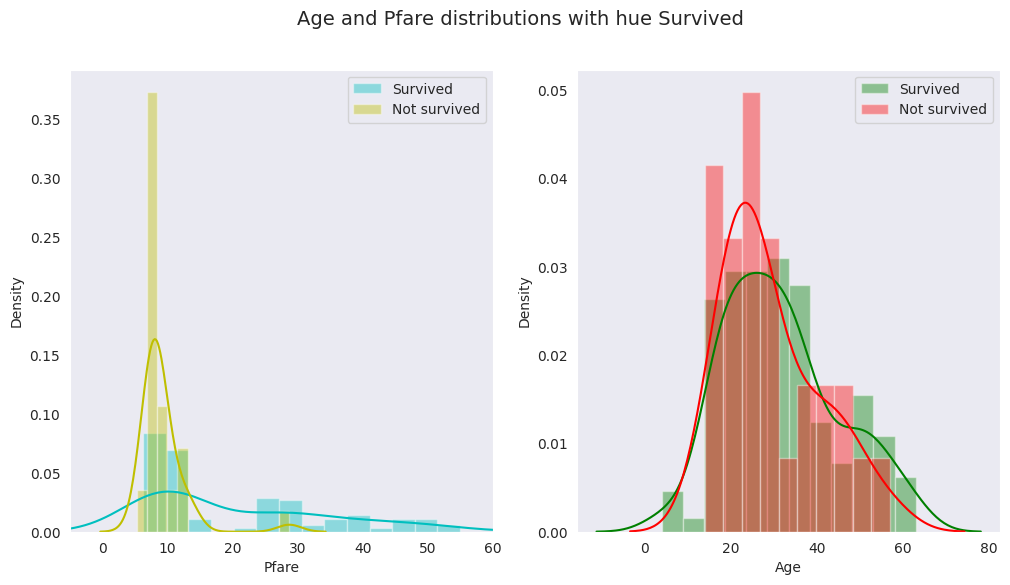

In [37]:
w1 = train_female.loc[train_female['Survived']==1, 'Pfare']
w0 = train_female.loc[train_female['Survived']==0, 'Pfare']
z1 = train_female.loc[train_female['Survived']==1, 'Age']
z0 = train_female.loc[train_female['Survived']==0, 'Age']

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Age and Pfare distributions with hue Survived', fontsize=14)
sns.distplot(w1, bins=35, label = 'Survived', ax = ax[0], color = 'c')
sns.distplot(w0, bins=15, label = 'Not survived', ax = ax[0], color = 'y')
ax[0].set_xlim(-5, 60)
ax[0].legend()
sns.distplot(z1, bins=12, label = 'Survived', ax = ax[1], color = 'g')
sns.distplot(z0, bins=10, label = 'Not survived', ax = ax[1], color = 'r')
ax[1].legend()
fig.show()

In [38]:
from sklearn.metrics import make_scorer, precision_score, recall_score
# We set zero_division=0 to avoid raising errors
custom_precision = make_scorer(precision_score, pos_label=0, zero_division=0)
custom_recall = make_scorer(recall_score, pos_label=0)

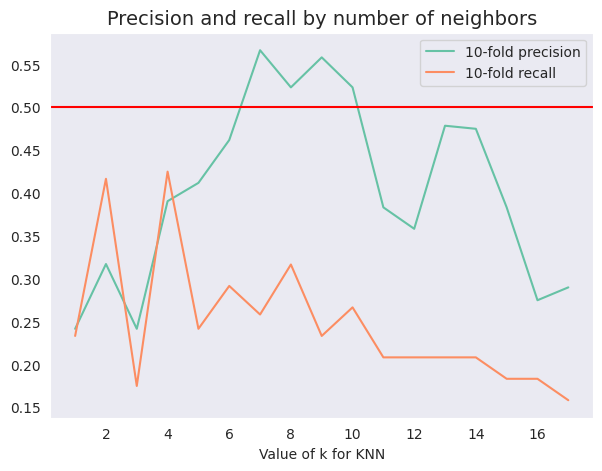

In [39]:
y_f = train_female['Survived']
X_f = train_female[features]
precision_f = []
recall_f = []
# Preprocessing is always the same...
for k in range(1,18):
    pipeline2 = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    # We use 9-fold because the train size is smaller
    # and 198/9 = integer
    precision_f.append(cross_val_score(pipeline2, X_f, y_f, cv=10, n_jobs=-1, scoring=custom_precision).mean())
    recall_f.append(cross_val_score(pipeline2, X_f, y_f, cv=10, n_jobs=-1, scoring=custom_recall).mean())
    
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_f, label='10-fold precision')
plt.plot(k_range, recall_f, label='10-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

In [40]:
from sklearn.model_selection import cross_validate

f1 = KNeighborsClassifier(n_neighbors=4)
f2 = KNeighborsClassifier(n_neighbors=9)
f3 = KNeighborsClassifier(n_neighbors=11)

# Preprocessing pipelines are the same as before
female_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting', VotingClassifier([
        ('f1', f1), ('f2', f2), ('f3', f3)]))
])

# Cross-validation scores
cv_results = cross_validate(
    female_pipeline, X_f, y_f, cv=10,
    scoring={
        'precision': custom_precision,
        'recall': custom_recall,
        'accuracy': 'accuracy'
    },
    return_train_score=True
)

print('=' * 60)
print('VALIDATION SCORES (Cross-Validation Results)')
print('=' * 60)
print(f'CV Score - Precision (9-fold): {cv_results["test_precision"].mean():.3f} (+/- {cv_results["test_precision"].std():.3f})')
print(f'CV Score - Recall (9-fold):    {cv_results["test_recall"].mean():.3f} (+/- {cv_results["test_recall"].std():.3f})')
print(f'CV Score - Accuracy (9-fold):  {cv_results["test_accuracy"].mean():.3f} (+/- {cv_results["test_accuracy"].std():.3f})')
print()
print('Train Scores (for comparison):')
print(f'Train Precision: {cv_results["train_precision"].mean():.3f}')
print(f'Train Recall:    {cv_results["train_recall"].mean():.3f}')
print(f'Train Accuracy:  {cv_results["train_accuracy"].mean():.3f}')
print('=' * 60)

# Preprocessing of training data, fit model
female_pipeline.fit(X_f, y_f)
learn_train_f = female_pipeline.predict(X_f)  # ← この行が抜けていました
X_test_f = test_female[features]
predictions_f = female_pipeline.predict(X_test_f)

print('\nThe following 6 non-WCG females are predicted to die:')
test_female.loc[(predictions_f==0), cols]

VALIDATION SCORES (Cross-Validation Results)
CV Score - Precision (9-fold): 0.583 (+/- 0.382)
CV Score - Recall (9-fold):    0.267 (+/- 0.178)
CV Score - Accuracy (9-fold):  0.829 (+/- 0.050)

Train Scores (for comparison):
Train Precision: 0.617
Train Recall:    0.290
Train Accuracy:  0.838

The following 6 non-WCG females are predicted to die:


,PassengerId,Name,Pfare,Pclass,Embarked
1060,1061,"Hellstrom, Miss. Hilda Maria",8.9625,3,S
1088,1089,"Nilsson, Miss. Berta Olivia",7.7750,3,S
1105,1106,"Andersson, Miss. Ida Augusta Margareta",7.7750,3,S
1236,1237,"Abelseth, Miss. Karen Marie",7.6500,3,S
1250,1251,"Lindell, Mrs. Edvard Bengtsson (Elin Gerda Per...",7.7750,3,S
1267,1268,"Kink, Miss. Maria",8.6625,3,S
1303,1304,"Henriksson, Miss. Jenny Lovisa",7.7750,3,S


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3544: UserWarning: 22.4% of the points cannot be placed; you may want to decrease the size of the mar

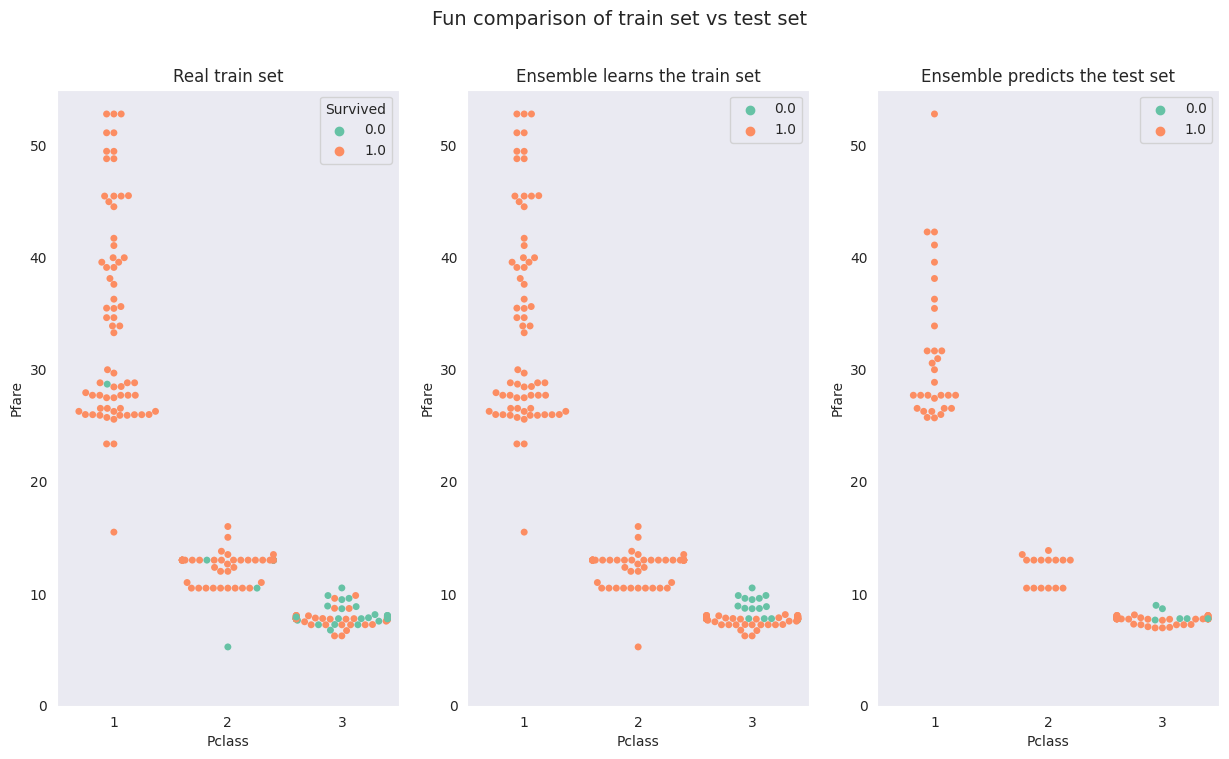

In [41]:
fig, ax = plt.subplots(1,3,figsize=(15,8))
fig.suptitle('Fun comparison of train set vs test set', fontsize=14)
ax[0].set_title('Real train set')
ax[0].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=y_f, ax=ax[0])
ax[1].set_title('Ensemble learns the train set')
ax[1].set_ylim(top=55)
sns.swarmplot(x=X_f.Pclass, y=X_f.Pfare, hue=learn_train_f,  ax=ax[1])
ax[2].set_title('Ensemble predicts the test set')
ax[2].set_ylim(top=55)
a = sns.swarmplot(x=test_female.Pclass, y=test_female.Pfare, hue=predictions_f,  ax=ax[2])

In [42]:
import os

data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = predictions_f

# Survived形式(Predict) → Perished形式に変換
output = pd.DataFrame({
    'PassengerId': data[891:1309].PassengerId, 
    'Perished': (1 - data[891:1309].Predict).astype('int')  # ← 反転
})

# outputフォルダがなければ作成
os.makedirs('../output', exist_ok=True)

output.to_csv('../output/knncopy.csv', index=False)
print('knncopy.csv was successfully saved to output folder!')

knncopy.csv was successfully saved to output folder!


/tmp/ipykernel_1558/3962600185.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data.loc[891:1308, 'Predict'][(data.Sex=='female') & (data.WCSurvived.isnull())] = predictions_f


In [43]:
# 訓練データ部分（元データにPerishedとSurvivedがある）
print('=== 訓練データ（元データ）の確認 ===')
check_train = data[0:20][['PassengerId', 'Perished', 'Survived', 'Sex', 'Pclass']].copy()
print(check_train)

print('\n=== Survived と Perished の関係 ===')
print('Survived=0 のとき Perished=', data[data.Survived==0]['Perished'].value_counts().index[0])
print('Survived=1 のとき Perished=', data[data.Survived==1]['Perished'].value_counts().index[0])

print('\n=== テストデータ部分（Predictを含む）===')
check_test = data[891:901][['PassengerId', 'Predict', 'Sex', 'Pclass']].copy()
print(check_test)

=== 訓練データ（元データ）の確認 ===
    PassengerId  Perished  Survived     Sex  Pclass
0             1       1.0       0.0    male       3
1             2       0.0       1.0  female       1
2             3       0.0       1.0  female       3
3             4       0.0       1.0  female       1
4             5       1.0       0.0    male       3
5             6       1.0       0.0    male       3
6             7       1.0       0.0    male       1
7             8       1.0       0.0    male       3
8             9       0.0       1.0  female       3
9            10       0.0       1.0  female       2
10           11       0.0       1.0  female       3
11           12       0.0       1.0  female       1
12           13       1.0       0.0    male       3
13           14       1.0       0.0    male       3
14           15       1.0       0.0  female       3
15           16       0.0       1.0  female       2
16           17       1.0       0.0    male       3
17           18       0.0       1.0    ma

In [44]:
# 訓練データで確認（Survivedの値がわかっているデータ）
print('=== 訓練データで確認 ===')
train_sample = data[0:891].loc[data[0:891].Survived.notna()].head(10)
print(train_sample[['PassengerId', 'Survived', 'Sex', 'Pclass']])

print('\n=== テストデータのPredict列 ===')
test_sample = data[891:901]
print(test_sample[['PassengerId', 'Predict', 'Sex', 'Pclass']])

print('\n=== 提出するPerished列 ===')
output_sample = pd.DataFrame({
    'PassengerId': data[891:901].PassengerId,
    'Perished': data[891:901].Predict.astype('int')
})
print(output_sample)

print('\n質問: Predict=1 は「生存」と「死亡」のどちら？')

=== 訓練データで確認 ===
   PassengerId  Survived     Sex  Pclass
0            1       0.0    male       3
1            2       1.0  female       1
2            3       1.0  female       3
3            4       1.0  female       1
4            5       0.0    male       3
5            6       0.0    male       3
6            7       0.0    male       1
7            8       0.0    male       3
8            9       1.0  female       3
9           10       1.0  female       2

=== テストデータのPredict列 ===
     PassengerId  Predict     Sex  Pclass
891          892      0.0    male       3
892          893      1.0  female       3
893          894      0.0    male       2
894          895      0.0    male       3
895          896      1.0  female       3
896          897      0.0    male       3
897          898      1.0  female       3
898          899      0.0    male       2
899          900      1.0  female       3
900          901      0.0    male       3

=== 提出するPerished列 ===
     PassengerId  Peri